In [24]:
import random
from queue import PriorityQueue
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
# Constants
ARRIVAL = 5.0
SIM_TIME = 100000
SERVICE_RATES = [1/5.0, 1/10.0, 1/15.0, 1/20.0, 1/25.0, 1/30.0, 1/35.0, 1/40.0, 1/45.0, 1/50.0, 1/55.0, 1/60.0, 1/65.0, 1/70.0, 1/75.0, 1/80.0, 1/85.0, 1/90.0, 1/95.0, 1/100.0]
TYPE1 = 1
REPETITIONS = 10
SEED_BASE = 100

In [26]:
class Measure:
    def __init__(self, Narr, Ndep, NAveraegUser, OldTimeEvent, AverageDelay):
        self.arr = Narr
        self.dep = Ndep
        self.ut = NAveraegUser
        self.oldT = OldTimeEvent
        self.delay = AverageDelay

In [27]:
class Client:
    def __init__(self, type, arrival_time):
        self.type = type
        self.arrival_time = arrival_time

In [28]:
def simulate_mm1(service_rate, seed_offset):
    global users, data, MM1
    users = 0
    data = Measure(0, 0, 0, 0, 0)
    MM1 = []
    time = 0
    FES = PriorityQueue()
    random.seed(SEED_BASE + seed_offset)

    def arrival(current_time):
        global users
        data.arr += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time
        inter_arrival = random.expovariate(1.0 / ARRIVAL)
        FES.put((current_time + inter_arrival, "arrival"))
        users += 1
        client = Client(TYPE1, current_time)
        MM1.append(client)
        if users == 1:
            st = random.expovariate(service_rate)
            FES.put((current_time + st, "departure"))

    def departure(current_time):
        global users
        data.dep += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time
        client = MM1.pop(0)
        data.delay += (current_time - client.arrival_time)
        users -= 1
        if users > 0:
            st = random.expovariate(service_rate)
            FES.put((current_time + st, "departure"))

    FES.put((0.0, "arrival"))
    while time < SIM_TIME:
        time, event_type = FES.get()
        if event_type == "arrival":
            arrival(time)
        elif event_type == "departure":
            departure(time)

    avg_delay = data.delay / data.dep if data.dep > 0 else 0
    return avg_delay


In [30]:

confidence_data = []
for rate in SERVICE_RATES:
    delays = [simulate_mm1(rate, seed) for seed in range(REPETITIONS)]
    mean = np.mean(delays)
    sem = stats.sem(delays)
    ci_low, ci_high = stats.t.interval(0.95, df=REPETITIONS-1, loc=mean, scale=sem)
    confidence_data.append({
        "Service Rate (μ)": round(rate, 4),
        "Avg Delay": mean,
        "95% CI Lower": ci_low,
        "95% CI Upper": ci_high
    })


In [31]:
# Create DataFrame and Plot
df_confidence_fast = pd.DataFrame(confidence_data)
mu_vals = df_confidence_fast["Service Rate (μ)"]
avg = df_confidence_fast["Avg Delay"]
err = df_confidence_fast["Avg Delay"] - df_confidence_fast["95% CI Lower"]


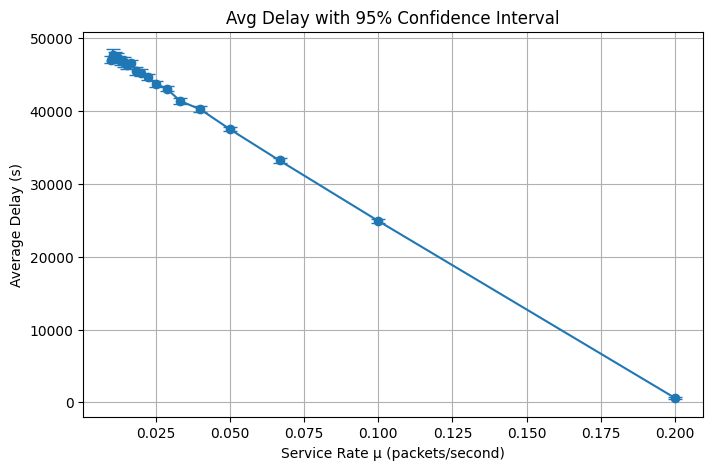

In [33]:
plt.figure(figsize=(8, 5))
plt.errorbar(mu_vals, avg, yerr=err, fmt='o-', capsize=5)
plt.xlabel("Service Rate μ (packets/second)")
plt.ylabel("Average Delay (s)")
plt.title("Avg Delay with 95% Confidence Interval")
plt.grid(True)
plt.show()